## GAN

In [1]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd
import sys
sys.path.insert(0, r'G:\My Drive\DNN')

from collections.abc import Callable
from typing import Literal

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix

In [2]:
###----------------------
### Some basic parameters
###----------------------


inpDir = '../input'
outDir = '../output'
modelDir = './models'
subDir = 'flower_photos'
altName = 'cnn_base'

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

TEST_SIZE = 0.2

ALPHA = 0.001
EPOCHS = 1000 # number of cycles to run
# PATIENCE = 20
# LR_PATIENCE = 10
# FACTOR_LR = 0.5
# BATCH_SIZE = 32 # inline of Training Rows being 60000
# IMG_HEIGHT = 190 # ??????????????
# IMG_WIDTH = 190 # ??????????????

# REG_LAMBDA = 0.001
# PATIENCE = 20 # EarlyStopping -> If n no. of epochs give similar o/p, then it will stop the execution
# LR_PATIENCE = 10
# LR_FACTOR = 0.1

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,10),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [3]:
def fn_plot_samples(smaples, m, n):
    fig, axes = plt.subplots(figsize = (n*2, m*2), # As per elements
                             nrows= m, ncols= n, # cols and rows
                             sharey= True, sharex= True) # smae axis for all imgs
    
    axes = axes.flatten()

    for ax, img in zip(axes, smaples):

        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

        im = ax.imshow(1 - img.reshape((2,2)), cmap= 'Greys_r') # show imgs

    return fig, axes

### Sigmoid Function

In [4]:
def fn_sigmoid(z):

    return 1.0 / (1.0 + (np.exp(-z)))

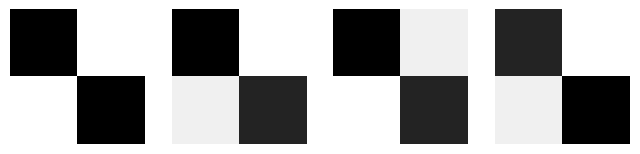

In [5]:
faces = [np.array([1.0, 0.0, 0.0, 1.0]),
         np.array([0.9, 0.1, 0.2, 0.8]),
         np.array([0.9, 0.2, 0.1, 0.8]),
         np.array([0.8, 0.1, 0.2, 0.9]),
         np.array([0.8, 0.2, 0.1, 0.9]),]

_ = fn_plot_samples(faces, 1, 4)

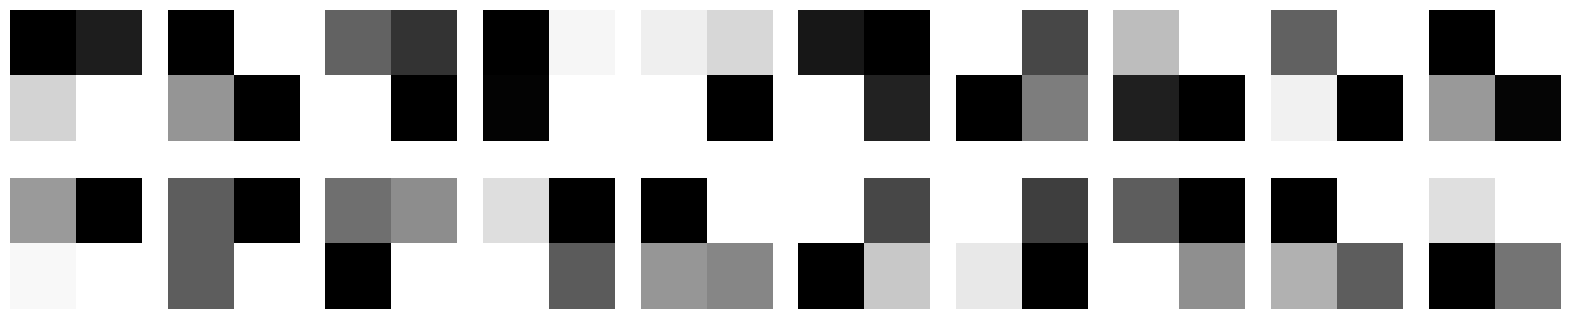

In [6]:
noise = [np.random.random((2,2)).round(2) for i in range(20)]

_ =  fn_plot_samples(noise, 2, 10)

In [7]:
nn_input_dim = 4

# Discriminator class
class Discriminator():
    def __init__(self):

        self.weights = np.random.rand(nn_input_dim) / np.sqrt(nn_input_dim)

        self.bias = 0.0 # bias can be zero
    
    # Forward Pass
    def forward(self, x):
        return fn_sigmoid(np.dot(x, self.weights) + self.bias)
    
    # Forward calculation error
    def image_error(self, image):
        prediction = self.forward(image)
        # We want the prediction to be 1 so the error is -log(prediction)
        return -np.log(prediction)
    
    # Derivatives for image
    def derivatives_from_image(self, image):
        y_pred = self.forward(image)
        dW = image * (y_pred - 1) #  (a-y)
        db = y_pred - 1
        return dW, db
    
    # Gradient Updates
    def update_from_image(self, x):
        dW, db = self.derivatives_from_image(x)
        self.weights = self.weights - (ALPHA*dW)
        self.bias = self.bias - (ALPHA*db)

    # Error from the noise
    def noise_error(self, noise):
        y_pred = self.forward(noise)
        # we want the prediction to be 0 so that the error is -log(1 - prediction)
        return -np.log(1 - y_pred)
    
    # Derivatives for noise
    def derivatives_from_noise(self, noise):
        y_pred = self.forward(noise)
        dW = noise * y_pred 
        db = y_pred
        return dW, db
    
    # Gradient Updates
    def update_from_noise(self, noise):
        dW, db = self.derivatives_from_noise(noise)
        self.weights -= (ALPHA * dW)
        self.bias -= (ALPHA * db)



In [11]:
# Generator class
class Generator():
    def __init__(self):

        self.weights = np.random.rand(nn_input_dim) / np.sqrt(nn_input_dim)

        self.biases = np.zeros(nn_input_dim) # as earlier bias can be zero
    
    # Forward Pass
    def forward(self, z):
        return fn_sigmoid(np.dot(z, self.weights) + self.biases) # activations from generated image
    
    # Calculation error
    def error(self, z, discriminator):
        x = self.forward(z)
        # Pass through the discriminator to get y
        y = discriminator.forward(x)
        # Generator wants discriminator to predict it as image (y = 1)
        return -np.log(y)
    
    # Derivatives
    def derivatives(self, z, discriminator):

        # Get discriminator weights and biases
        discriminator_weights = discriminator.weights
        discriminator_bias = discriminator.bias

        # forwards pass of z
        x = self.forward(z) # activations from Generator
        y = discriminator.forward(x) # activation from Generator submitted to discriminator
        factor = - ( 1 - y) * discriminator_weights * x * (1 - x) # - [1 - D(G(z))].W.
        dW = factor * z # mulitply factor by z
        db = factor
        return dW, db

    # Updates Generator Weights
    def update(self, z, discriminator):
        dW, db = self.derivatives(z, discriminator)
        self.weights -= ALPHA * dW
        self.biases -= ALPHA * db



In [12]:
D = Discriminator()
G = Generator()

errors_discriminator = []
errors_generator = []

for epoch in range(EPOCHS):
    for face in faces:
        D.update_from_image(face)
        z = np.random.rand()
        errors_discriminator.append(sum(D.image_error(face) + D.noise_error(z)))
        errors_generator.append(G.error(z, D))
        noise = G.forward(z)
        D.update_from_noise(noise)
        G.update(z, D)

In [16]:
generated_images = []

for i in range(100):
    z = np.random.random()

    generated_image = G.forward(z)

    generated_images.append(generated_image)

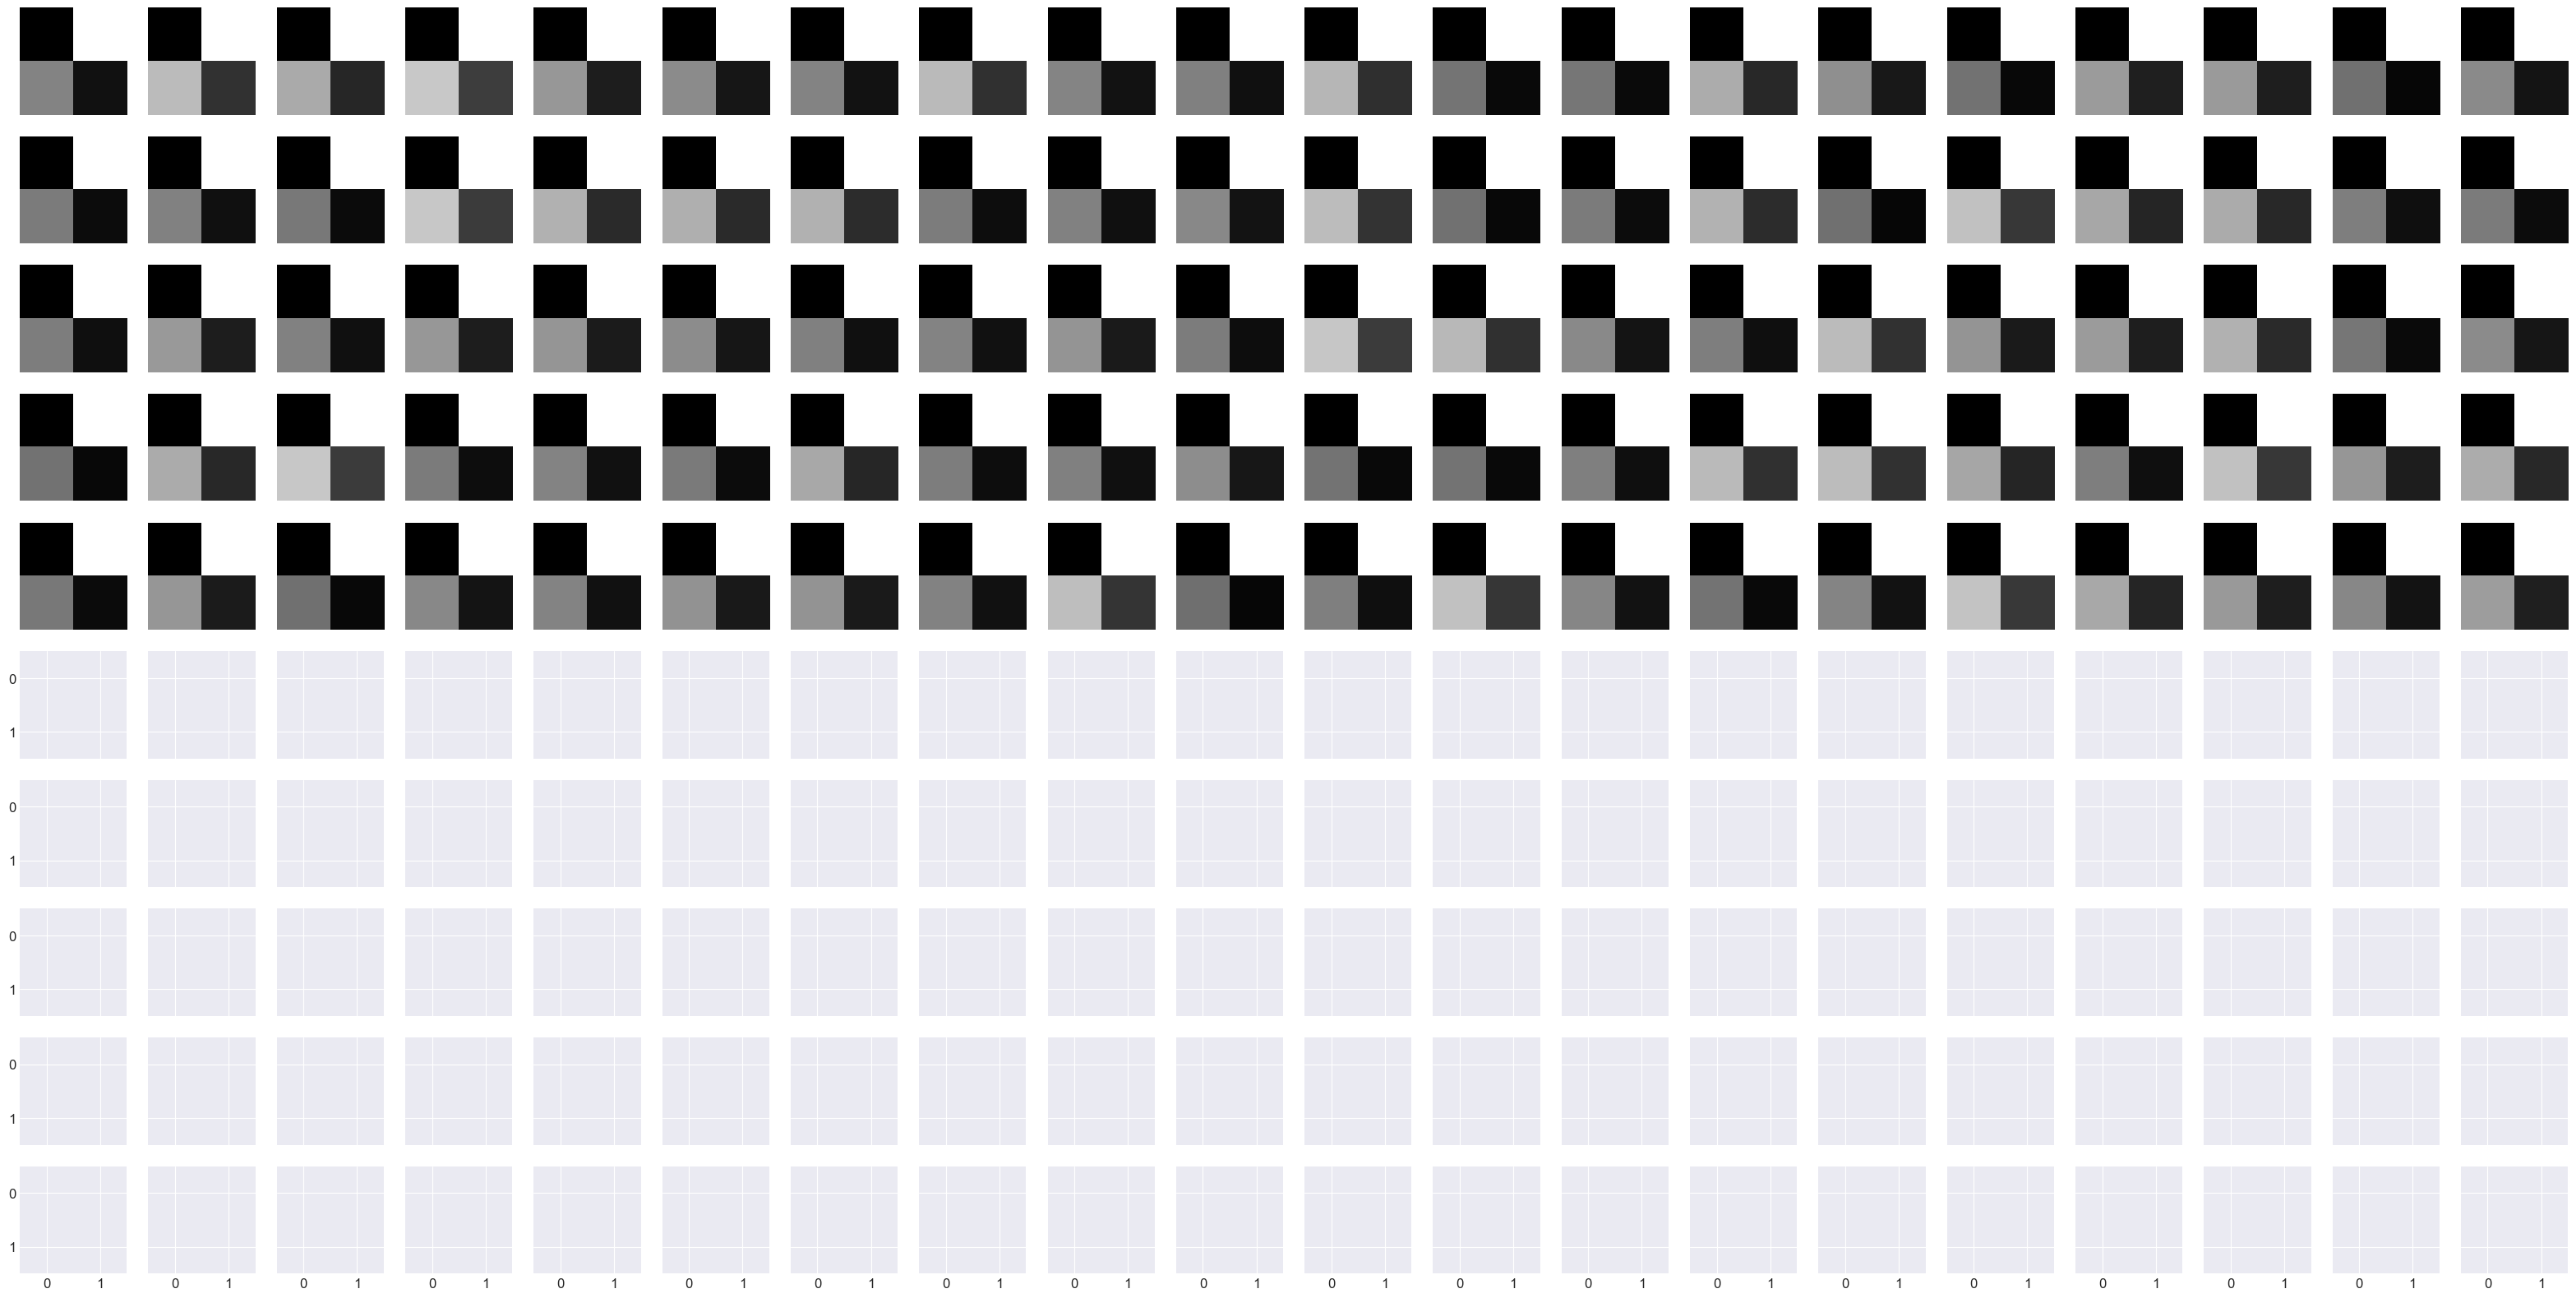

In [18]:
_ = fn_plot_samples(generated_images, 10, 20)